In [2]:

%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['savefig.dpi'] = 144

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

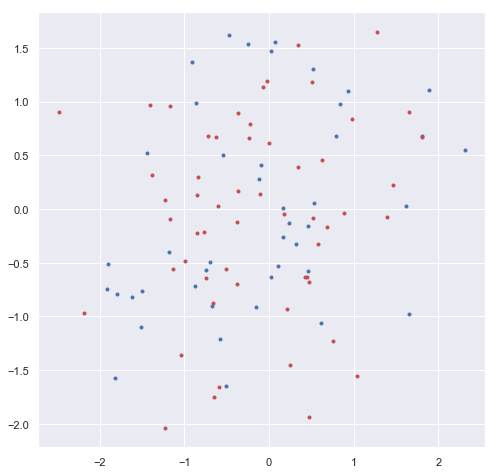

In [3]:
x1 = np.random.randn(100)
x2 = np.random.randn(100)
y = np.random.choice([True, False], size=100)

plt.figure(figsize=(8,8))
plt.plot(x1[y], x2[y], 'b.')
plt.plot(x1[~y], x2[~y], 'r.');

In [4]:
rand_df = pd.DataFrame(np.vstack([x1, x2, y]).T, columns=['x1', 'x2', 'y'])

In [5]:
rand_df.corr()

,x1,x2,y
x1,1.000000,0.236313,0.002357
x2,0.236313,1.000000,0.022491
y,0.002357,0.022491,1.000000


# FEATURE EXTRACTION

In [6]:
temps = pd.read_csv('./data/land_temps_by_city.csv', parse_dates=[0])

In [7]:
temps.head()


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1900-02-01,0.969,0.585,Berlin,Germany,52.24N,13.14E
1,1900-03-01,1.313,0.328,Berlin,Germany,52.24N,13.14E
2,1900-04-01,7.246,0.317,Berlin,Germany,52.24N,13.14E
3,1900-05-01,12.125,0.240,Berlin,Germany,52.24N,13.14E
4,1900-06-01,17.362,0.343,Berlin,Germany,52.24N,13.14E


In [8]:
from functools import reduce

In [9]:
def collect (x):
    return reduce (lambda y,z: y +[z] 
                   if isinstance(y, list) else [z], x)

def estimated_autocorrelation(x):
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

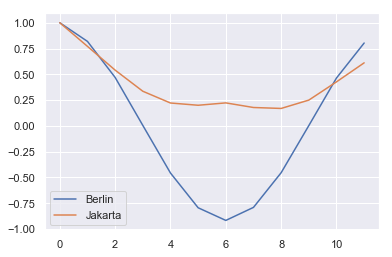

In [10]:
plt.plot(estimated_autocorrelation(temps[temps['City']=='Berlin']['AverageTemperature'].values)[:12], label='Berlin')
plt.plot(estimated_autocorrelation(temps[temps['City']=='Jakarta']['AverageTemperature'].values)[:12], label='Jakarta')
plt.legend();

In [11]:
ac = temps.groupby('City')['AverageTemperature'].apply(collect).apply(lambda x: np.array(x)).apply(estimated_autocorrelation).rename('autocorr')
ac_lat = pd.concat([ac.apply(lambda x: x[range(6, 1362, 12)].mean()), temps[['City', 'Latitude']].drop_duplicates().set_index('City')], axis=1)
ac_lat['Latitude'] = ac_lat['Latitude'].apply(lambda x: float(x[:-1]))

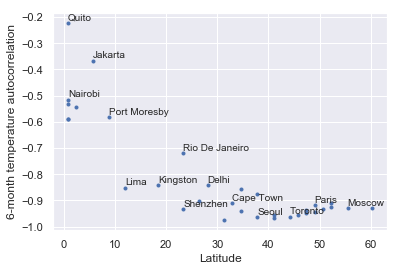

In [12]:
plt.plot(ac_lat['Latitude'], ac_lat['autocorr'], '.')
plt.xlabel('Latitude')
plt.ylabel('6-month temperature autocorrelation');

ax = plt.gca()
labels = {'Lima', 'Shenzhen', 'Delhi', 'Lima', 'Kingston', 'Cape Town', 'Jakarta', 'Nairobi', 'Rio De Janeiro', 'Quito', 'Port Moresby', 'Seoul', 'Moscow', 'Paris', 'Toronto'}
for city in ac_lat.index:
    if city in labels:
        plt.text(ac_lat.loc[city, 'Latitude'], ac_lat.loc[city, 'autocorr'] + .01, city)

# Feature Transformation

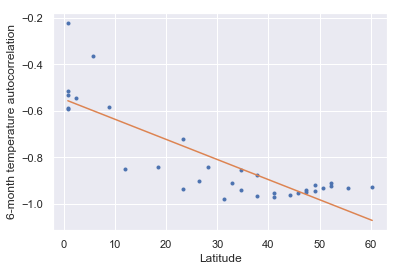

In [13]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression().fit(ac_lat['Latitude'].values.reshape(-1, 1), ac_lat['autocorr'].values.reshape(-1, 1))

ac_lat.sort_values('Latitude', inplace=True)

plt.plot(ac_lat['Latitude'], ac_lat['autocorr'], '.')
plt.plot(ac_lat['Latitude'], lin_reg.predict(ac_lat['Latitude'].values.reshape(-1, 1)))
plt.xlabel("Latitude")
plt.ylabel('6-month temperature autocorrelation');

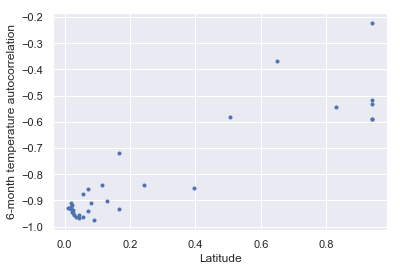

In [14]:
plt.plot(np.exp(-ac_lat['Latitude']/13), ac_lat['autocorr'], '.')
plt.xlabel('Latitude')
plt.ylabel('6-month temperature autocorrelation');

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.utils import shuffle

X_train, X_test, y_train, y_test = train_test_split(*shuffle(ac_lat['Latitude'].values.reshape(-1, 1), ac_lat['autocorr'].values.reshape(-1, 1)), test_size=0.1)

lin_reg = LinearRegression()

lin_reg.fit(np.exp(-X_train/13), y_train)

lin_pred = lin_reg.predict(np.exp(-X_test/13))

# compare with the decision tree model


In [16]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=3)
tree_reg.fit(X_train, y_train)
tree_pred = tree_reg.predict(X_test)

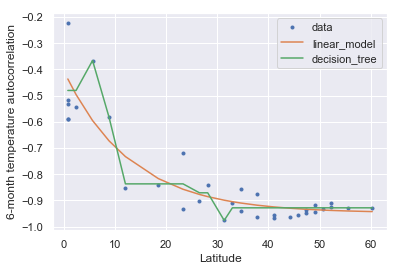

In [17]:
ac_lat.sort_values('Latitude', inplace=True)

plt.plot(ac_lat['Latitude'], ac_lat['autocorr'], '.', label='data')
plt.plot(ac_lat['Latitude'], lin_reg.predict(np.exp(-ac_lat['Latitude'].values.reshape(-1, 1) / 13)), label= 'linear_model')
plt.plot(ac_lat['Latitude'], tree_reg.predict(ac_lat['Latitude'].values.reshape(-1, 1)), label= 'decision_tree')
plt.xlabel('Latitude')
plt.ylabel('6-month temperature autocorrelation')
plt.legend()

In [18]:
print('Transformed linear regression: %0.2f' % mse(y_test, lin_pred))
print('Decision tree regression: %0.2f' % mse(y_test, tree_pred))

Transformed linear regression: 0.01
Decision tree regression: 0.00


# Curse of dimensionality

Score on 1D data: 0.89
Score on 2D data: 0.94


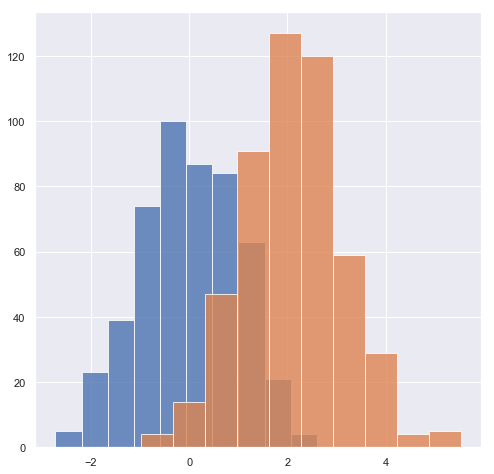

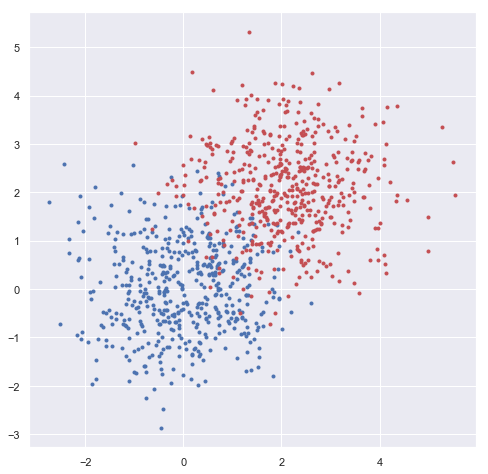

In [19]:
n = 1000
x1 = np.concatenate([np.random.randn(n // 2), np.random.randn(n // 2) + 2])
y = np.array([True if i < n // 2 else False for i in range(n)])

plt.figure(figsize=(8,8))
plt.hist(x1[y], alpha=.8)
plt.hist(x1[~y], alpha=.8);

x2 = np.concatenate([np.random.randn(n // 2), np.random.randn(n // 2) + 2])

plt.figure(figsize=(8,8))
plt.plot(x1[y], x2[y], 'b.')
plt.plot(x1[~y], x2[~y], 'r.');

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(np.vstack([x1, x2]).T, y)

log_reg_1d = LogisticRegression(solver='lbfgs').fit(np.atleast_2d(X_train[:, 0]).T, y_train)

log_reg_2d = LogisticRegression(solver='lbfgs').fit(X_train, y_train)

print('Score on 1D data: %0.2f' % accuracy_score(y_test, log_reg_1d.predict(np.atleast_2d(X_test[:, 0]).T)))
print('Score on 2D data: %0.2f' % accuracy_score(y_test, log_reg_2d.predict(X_test)))

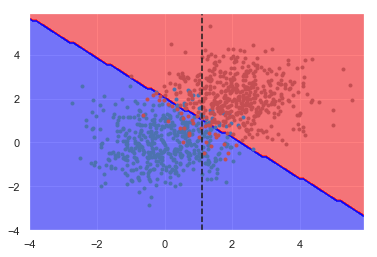

In [20]:
from matplotlib.colors import ListedColormap

xx1, xx2 = np.meshgrid(np.arange(-4, 6, .1), np.arange(-4, 6, .1))

Z = log_reg_2d.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
Z = Z.reshape(xx1.shape)

cut_1d = np.arange(-4, 6, .1)[log_reg_1d.predict_proba(np.atleast_2d(np.arange(-4,6,.1)).T)[:, 0] > .5][0]

colors = ('red', 'blue')
cmap = ListedColormap(colors)

plt.contourf(xx1, xx2, Z, alpha=0.5, cmap=cmap)
plt.plot(x1[y], x2[y], 'b.')
plt.plot(x1[~y], x2[~y], 'r.')
plt.axvline(cut_1d, color='k', linestyle='--');

# FEATURE IMPORTANCE
To avoid the curse of dimensionality, we'll sometimes want to reduce the dimensionality of our data. We may also want to reduce the dimensionality of our data simply to compress it (in the case of very large data) or simply to visualize the data. Reducing dimensionality also helps make models more interpretable. When reducing the dimensionality of the data, we will want to get rid of irrelevant or redundant features.

In [24]:
from sklearn.datasets import fetch_california_housing

In [25]:
cali_data = fetch_california_housing()

cali_df = pd.DataFrame(cali_data.data, columns=cali_data.feature_names)

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
import scipy.stats

X_train, X_test, y_train, y_test = train_test_split(*shuffle(cali_df, cali_data.target), test_size=0.1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

model = DecisionTreeRegressor()

rs = RandomizedSearchCV(model,
                  {'max_depth': scipy.stats.binom(9, .3, loc=1),
                  'min_samples_split': scipy.stats.binom(90, .5, loc=10)},
                   cv=5,
                   n_iter=200,
                   n_jobs=4,
                   scoring='neg_mean_squared_error')

rs.fit(X_train, y_train)
print(r2_score(y_test, rs.best_estimator_.predict(scaler.transform(X_test))))

list(zip(cali_data.feature_names, rs.best_estimator_.feature_importances_))

0.6525223952925385


[('MedInc', 0.6967699630449733),
 ('HouseAge', 0.03962662786274949),
 ('AveRooms', 0.030101054157087356),
 ('AveBedrms', 0.0017965647883460808),
 ('Population', 0.00753977356544303),
 ('AveOccup', 0.1406090999464734),
 ('Latitude', 0.043659415262970395),
 ('Longitude', 0.039897501371957016)]

In [27]:
#for linear regression
X_train, X_test, y_train, y_test = train_test_split(*shuffle(cali_df, cali_data.target), test_size=0.1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

lin_reg = LinearRegression().fit(X_train, y_train)

print(r2_score(y_test, lin_reg.predict(scaler.transform(X_test))))

list(zip(cali_data.feature_names, abs(lin_reg.coef_) / sum(abs(lin_reg.coef_))))
#abs - absolute value

0.6085209028776829


[('MedInc', 0.2483094733783737),
 ('HouseAge', 0.03578474161999199),
 ('AveRooms', 0.07970848152755387),
 ('AveBedrms', 0.09110616597934454),
 ('Population', 0.0015313825477368734),
 ('AveOccup', 0.011856162505567277),
 ('Latitude', 0.27046356023359225),
 ('Longitude', 0.2612400322078394)]

In [28]:
#for linear regression
X_train, X_test, y_train, y_test = train_test_split(*shuffle(cali_df, cali_data.target), test_size=0.1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

lin_reg = LinearRegression().fit(X_train, y_train)

print(r2_score(y_test, lin_reg.predict(scaler.transform(X_test))))

list(zip(cali_data.feature_names, abs(lin_reg.coef_) / sum(abs(lin_reg.coef_))))
#abs - absolute value

0.5705324129058122


[('MedInc', 0.24964413350721498),
 ('HouseAge', 0.03561246281399974),
 ('AveRooms', 0.08290840008475939),
 ('AveBedrms', 0.09655611310293434),
 ('Population', 0.0007062724008650369),
 ('AveOccup', 0.011780530383378661),
 ('Latitude', 0.26556374292703944),
 ('Longitude', 0.25722834477980844)]

# Feature selecting

In [29]:
from sklearn.feature_selection import RFECV

feature_elimination = RFECV(estimator=model, cv=5, scoring='r2')
feature_elimination.fit(X_train, y_train);

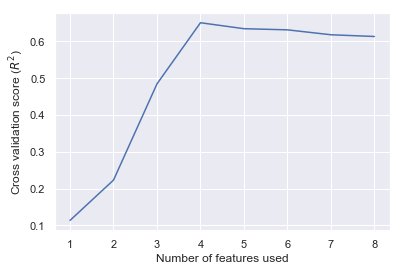

In [27]:
rfecv_scores = feature_elimination.grid_scores_
plt.plot(range(1, len(rfecv_scores) + 1), rfecv_scores)
plt.xlabel('Number of features used')
plt.ylabel(r'Cross validation score ($R^2$)');

In [28]:
rfecv_scores

array([0.11360506, 0.22324944, 0.48473664, 0.65096947, 0.6347944 ,
       0.63168467, 0.61830915, 0.61360104])

# Regularization

In [29]:
from sklearn.linear_model import Ridge, Lasso
X_train, X_test, y_train, y_test = train_test_split(*shuffle(cali_df, cali_data.target), test_size=0.1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

lin_reg = LinearRegression().fit(X_train, y_train)

alphas = np.logspace(-2, 2, 100)
ridge_coefs = []
ridge_scores = []
lasso_coefs = []
lasso_scores = []
for alpha in alphas:
    ridge_reg = Ridge(alpha=alpha).fit(X_train, y_train)
    lasso_reg = Lasso(alpha=alpha).fit(X_train, y_train)
    ridge_coefs.append(ridge_reg.coef_)
    ridge_scores.append(r2_score(y_test, ridge_reg.predict(scaler.transform(X_test))))
    lasso_coefs.append(lasso_reg.coef_)
    lasso_scores.append(r2_score(y_test, lasso_reg.predict(scaler.transform(X_test))))

lin_score = r2_score(y_test, lin_reg.predict(scaler.transform(X_test)))
print('Linear regression score: %0.2f' % lin_score)
print('Ridge regression score: %0.2f' % max(ridge_scores))
print('Lasso regression score: %0.2f' % max(lasso_scores))

Linear regression score: 0.60
Ridge regression score: 0.60
Lasso regression score: 0.60


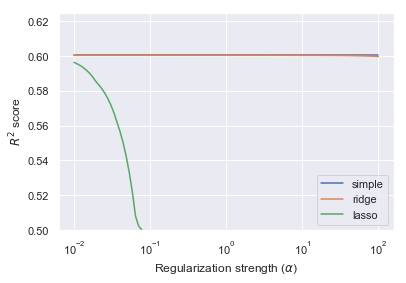

In [30]:
plt.figure()
plt.gca().set_xscale('log')
plt.gca().set_ylim([.5, .625])
plt.plot(alphas, np.repeat(lin_score, len(alphas)), label='simple')
plt.plot(alphas, ridge_scores, label='ridge')
plt.plot(alphas, lasso_scores, label='lasso')
plt.xlabel(r'Regularization strength ($\alpha$)')
plt.ylabel(r'$R^2$ score')
plt.legend();


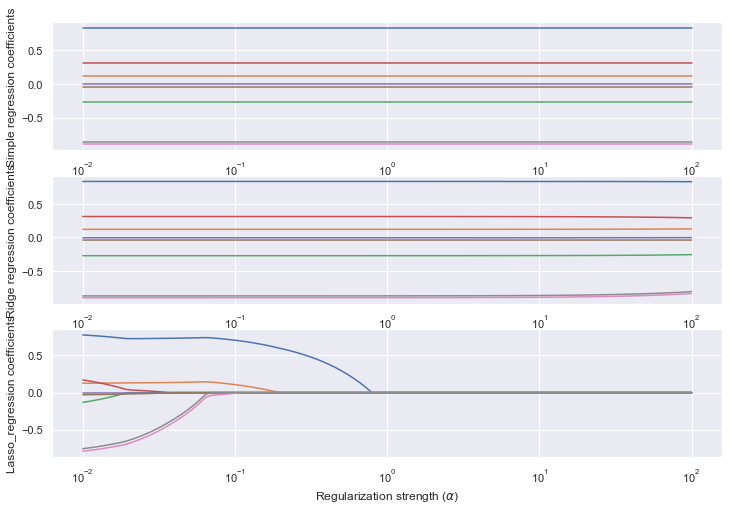

In [31]:
plt.figure(figsize=[12, 8])
plt.title('Regression coefficients')

plt.subplot(311)
plt.gca().set_xscale('log')
plt.ylabel('Simple regression coefficients')
for coef in lin_reg.coef_:
    plt.plot(alphas, np.repeat(coef, len(alphas)))

plt.subplot(312)
plt.gca().set_xscale('log')
plt.ylabel('Ridge regression coefficients')
plt.plot(alphas, ridge_coefs)

plt.subplot(313)
plt.gca().set_xscale('log')
plt.ylabel('Lasso_regression coefficients')
plt.xlabel(r'Regularization strength ($\alpha$)')
plt.plot(alphas, lasso_coefs);

In [32]:
np.repeat?

In [33]:
list(zip(cali_data.feature_names, lasso_coefs[20]))

[('MedInc', 0.7417177455395134),
 ('HouseAge', 0.14502900620419576),
 ('AveRooms', -0.0),
 ('AveBedrms', 0.0),
 ('Population', 0.0),
 ('AveOccup', -0.0),
 ('Latitude', -0.06355133450303059),
 ('Longitude', -0.022981147878734055)]

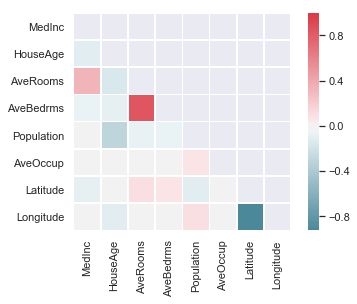

In [34]:
corr = cali_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, center=0, vmax=1);

In [35]:
mask

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True,  True],
       [False, False, False, False, False,  True,  True,  True],
       [False, False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False, False,  True]])

# PCA

In [36]:
from ipywidgets import interact

def plot_data(rotation=0):
    x1_r = x1 * np.cos(rotation) + x2 * np.sin(rotation)
    x2_r = -x1 * np.sin(rotation) + x2 * np.cos(rotation)
    plt.plot(x1_r[y], x2_r[y], 'b.')
    plt.plot(x1_r[~y], x2_r[~y], 'r.')

    w1, w2 = log_reg_2d.coef_[0]
    x = np.sort(x1)
    line = (-log_reg_2d.intercept_ - w1 * x) / w2
    x_r = x * np.cos(rotation) + line * np.sin(rotation)
    line_r = -x * np.sin(rotation) + line * np.cos(rotation)
    plt.plot(x_r, line_r)
    
interact(plot_data, rotation=(0, np.pi, .1));

interactive(children=(FloatSlider(value=0.0, description='rotation', max=3.141592653589793), Output()), _dom_c…

In [37]:
 from sklearn.decomposition import PCA

X_train, X_test, y_train, y_test = train_test_split(np.vstack([x1, x2]).T, y)

pca = PCA(n_components=1)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

log_reg_pca = LogisticRegression(solver='lbfgs').fit(X_pca_train, y_train)

print('Score on 2D data: %0.2f' % accuracy_score(y_test, log_reg_2d.predict(X_test)))
print('Score on 1D data (PCA): %0.2f' % accuracy_score(y_test, log_reg_pca.predict(X_pca_test)))

Score on 2D data: 0.90
Score on 1D data (PCA): 0.91


# ensemble models
Uses predictions of different estimators to make predictions 

# 1. RandomForest

In [38]:
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(*shuffle(cali_df, cali_data.target), test_size=.1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [39]:
model  = RandomForestRegressor(n_estimators=50)

gs  = GridSearchCV(model, {'max_features': np.arange(.05,1,.05)},
                            cv=5,
                           n_jobs = 4,
                           scoring = 'neg_mean_squared_error')

gs.fit(X_train, y_train);

KeyboardInterrupt: 

In [ ]:
model = gs.best_estimator_

print (gs.best_estimator_)
print (r2_score(y_test, model.predict(scaler.transform(X_test))))

In [ ]:
gs = GridSearchCV(model,
                 {'min_samples_leaf': np.arange(1,50,5)},
                 cv=5,
                 n_jobs=4,
                 scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

In [ ]:
model = gs.best_estimator_

In [ ]:
param_grid = {#'min_samples_leaf': np.arange(1,50,5),
             'n_estimators': np.arange(10, 51, 10),
             'max_features': np.arange(.05,1,.05)
             }

In [ ]:
model = RandomForestRegressor(n_estimators=50)

In [ ]:
grid_search = GridSearchCV(model,
                          param_grid=param_grid,
                          cv=5,
                          n_jobs=4,
                          scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train);


# custom ensembles


In [ ]:

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, ClassifierMixin, MetaEstimatorMixin

In [ ]:
class ESTransformer (BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator
    def fit (self, X, y):
        self.estimator.fit(X,y)
        return self
    def transform (self, X):
        return np.atleast_2d(self.estimator.predict(X)).T

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeRegressor
X_train, X_test, y_train, y_test = train_test_split(*shuffle(cali_df, cali_data.target), test_size = 0.1)

In [ ]:
knn = Pipeline([('scaler', scaler), ('knn', KNeighborsRegressor())])

In [ ]:
knn.get_params()

In [ ]:
gs = GridSearchCV(knn,
                 {'knn__n_neighbors':range(5,26,5)},
                 n_jobs=4,
                 cv=5,
                 scoring='neg_mean_squared_error')

In [ ]:
gs.fit(X_train, y_train);

In [ ]:
print(gs.best_estimator_)

print(r2_score(y_test, gs.best_estimator_.predict(X_test)))

In [ ]:
ensemble = FeatureUnion([
    ('rf', ESTransformer(DecisionTreeRegressor(max_depth=5, min_samples_split=45))),
    ('knn', ESTransformer(KNeighborsRegressor(n_neighbors=10)))
])

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ensemble', ensemble),
    ('combine', LinearRegression(fit_intercept=False))
])

pipe.fit(X_train, y_train);



In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
pipe.score(X_test, y_test)

In [ ]:
print (r2_score(y_test, pipe.predict(X_test)))

# Bias and Variance

In [36]:
data = fetch_california_housing()


In [37]:
X = data.data
y = data.target

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=0)

In [39]:
import matplotlib.pyplot as plt

In [42]:
rgr = DecisionTreeRegressor(max_depth=5)
rgr.fit(X_train, y_train)

print ('training R^2: {}'.format(rgr.score(X_train, y_train)))
print ('testing R^2: {}'.format(rgr.score(X_test, y_test)))

training R^2: 0.6330284837264881
testing R^2: 0.598388960870144


In [53]:
rgr = DecisionTreeRegressor(max_depth=3)
error_test = []
error_train = []


for n in range(50, X_train.shape[0], 50):
    X_batch = X_train[:n, :]
    y_batch = y_train[:n]
    
    rgr.fit(X_batch, y_batch)
    error_test.append(1-rgr.score(X_test, y_test))
    error_train.append(1-rgr.score(X_batch, y_batch))

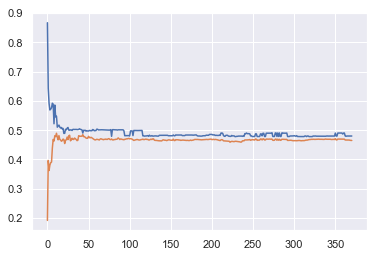

In [54]:
plt.plot(error_test)
plt.plot(error_train)